## Multiple regression for object-selectivity
This code runs two nested multiple linear regression: one with object-related regressors and the 
other with both object and choice regressors.

R-squared valuese of the two models are compared and if choice regressors improve the model a lot, the neuron is considered to have significant choice information, rather than object identity.


In [3]:
import os
import numpy as np
import pandas as pd

from scipy import stats
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LinearRegression

import matplotlib as mpl
import matplotlib.pyplot as plt  

from datetime import date
import time

import random

from joblib import Parallel, delayed

import h5py

In [4]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [5]:
mother_path = 'D:/Multi-modal project/'

### Parameter setting

In [6]:
num_shuffle = 10

gauss_sigma = 1

# colors for multimodal, vis-only, aud-only conditions
color = ['mediumorchid','cornflowerblue','lightcoral','gray']
color2 = ['cyan','magenta','brown']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [7]:
unit_summary = pd.read_table(mother_path+'/analysis/result'+
                             '/1. Cluster summary/clusterSummary.csv',sep=',')
save_path = mother_path+'analysis/result/3. Multiple regression for object-selectivity/'
data_path = mother_path+'analysis/result/zFR export/13-Apr-2022 (5 trials)/'

os.makedirs(save_path+today,exist_ok=True)
f = h5py.File(save_path+today+'/'+today+'_multiple_regression_result.hdf5','w')

os.chdir(data_path)
cell_list = os.listdir(os.curdir)

# Data analysis

In [8]:
def compute_regression(t):
    y = fr[subsample,t]
    
    lr1 = LinearRegression().fit(x1,y)
    lr2 = LinearRegression().fit(x2,y)
    
    lr1_shuffle = LinearRegression().fit(x1_shuffle,y)
    lr2_shuffle = LinearRegression().fit(x2_shuffle,y)
    
    return lr1.coef_, lr2.coef_, lr1_shuffle.coef_, lr2_shuffle.coef_, lr1.score(x1,y),lr2.score(x2,y),lr1_shuffle.score(x1_shuffle,y),lr2_shuffle.score(x2_shuffle,y)

In [9]:
def groupby_index(df):

    gb = df.groupby(['Visual', 'Auditory'])

    Boy_M_id = gb.get_group(('Boy', boy_aud)).index.to_numpy()
    Boy_V_id = gb.get_group(('Boy', 'no')).index.to_numpy()
    Boy_A_id = gb.get_group(('no', boy_aud)).index.to_numpy()
    
    Egg_M_id = gb.get_group(('Egg', egg_aud)).index.to_numpy()
    Egg_V_id = gb.get_group(('Egg', 'no')).index.to_numpy()
    Egg_A_id = gb.get_group(('no', egg_aud)).index.to_numpy()
    
    C_L_id = gb.get_group(('Left', 'no')).index.to_numpy()
    C_R_id = gb.get_group(('Right', 'no')).index.to_numpy()

    cond_id = [Boy_M_id, Boy_V_id, Boy_A_id, Egg_M_id, Egg_V_id, Egg_A_id, C_L_id, C_R_id]  
    
    return cond_id

In [10]:
def plot_SDF_beta(df,linewidth,smooth,save,save_format):
    cond = [(df.Type=='Multimodal')&(df.RWD_Loc==boy_goal),
            (df.Type=='Multimodal')&(df.RWD_Loc==egg_goal),
            (df.Type=='Visual')&(df.RWD_Loc==boy_goal),
            (df.Type=='Visual')&(df.RWD_Loc==egg_goal),
            (df.Type=='Auditory')&(df.RWD_Loc==boy_goal),
            (df.Type=='Auditory')&(df.RWD_Loc==egg_goal),
            (df.Type=='Elemental')&(df.RWD_Loc==boy_goal),
            (df.Type=='Elemental')&(df.RWD_Loc==egg_goal)]
    
    fr_mean = np.zeros((len(cond),95))
    fr_sem = np.zeros((len(cond),95))
    for i in range(len(cond)):
        fr_mean[i,:] = df[cond[i]].iloc[:,fr_id:fr_id+95].to_numpy().mean(axis=0)
        fr_sem[i,:] = stats.sem(df[cond[i]].iloc[:,fr_id:fr_id+95].to_numpy())
    
    if smooth:
        for i in range(len(cond)):
            fr_mean[i,:] = gaussian_filter(fr_mean[i,:],sigma=gauss_sigma)
            fr_sem[i,:] = gaussian_filter(fr_sem[i,:],sigma=gauss_sigma)
            
    y_max = np.ceil(np.max(fr_mean+fr_sem))
    y_min = np.ceil(np.abs(np.min(fr_mean-fr_sem)))*-1
    
    fig,ax = plt.subplots(3,3,figsize=(15,10))
    plt.suptitle(cell_name.strip('.csv'),fontsize=15);
    x = np.arange(95)*10
    
    for i in range(len(cond)):
        if i%2==0:
            ls = linestyle[0]
        else:
            ls = linestyle[1]            
        ax[0,0].plot(x,fr_mean[i,:],color=color[int(np.floor(i/2))],linewidth=linewidth,linestyle=ls)
        ax[0,0].fill_between(x,fr_mean[i,:]-fr_sem[i,:],fr_mean[i,:]+fr_sem[i,:],color=color[int(np.floor(i/2))],alpha=0.2)
        
        ax[i%2+1,0].plot(x,fr_mean[i,:],color=color[int(np.floor(i/2))],linewidth=linewidth,linestyle=ls)
        ax[i%2+1,0].fill_between(x,fr_mean[i,:]-fr_sem[i,:],fr_mean[i,:]+fr_sem[i,:],color=color[int(np.floor(i/2))],alpha=0.2)
        
        if i<6:
            ax[int(np.floor(i/2)),1].plot(x,fr_mean[i,:],color=color[int(np.floor(i/2))],linewidth=linewidth,linestyle=ls)
            ax[int(np.floor(i/2)),1].fill_between(x,fr_mean[i,:]-fr_sem[i,:],fr_mean[i,:]+fr_sem[i,:],color=color[int(np.floor(i/2))],alpha=0.2)
    
    # control stimulus SDF
    for i in range(3):
        ax[i,1].plot(x,fr_mean[6,:],color=color[3])
        ax[i,1].plot(x,fr_mean[7,:],color=color[3],linestyle=':')
            
    for i in range(6):
        ax[i%3,int(np.floor(i/3))].set_yticks(np.arange(y_min,y_max+0.1,1))
        ax[i%3,int(np.floor(i/3))].set_ylabel('z-scored FR',fontsize=13)
        ax[i%3,int(np.floor(i/3))].set_xlabel('Time (ms)',fontsize=13)  
        ax[i%3,int(np.floor(i/3))].set_xticks([0,400,950])
        ax[i%3,int(np.floor(i/3))].set_xlim([0,950])    
    
    # beta coefficient plot
    t2 = ['Visual term','Auditory term','Interaction term']
    c2 = ['blue','red','green']
    for i in range(3):
        ax[i,2].plot(x,beta_mean[:,i],color=c2[i],linestyle='-',linewidth=linewidth)
        ax[i,2].plot(x,beta_mean[:,i+3],color=c2[i],linestyle=':',linewidth=linewidth)
        
        ax_r = ax[i,2].twinx()
        ax_r.plot(x,r_diff,color='lightgray',linewidth=1)
        ax_r.set_ylabel('R-squared difference')   
        #ax_r.set_yticks(np.arange(0,0.21,0.04))       
            
        ax[i,2].set_title(t2[i],fontsize=13)
        ax[i,2].set_yticks(np.arange(-1,1.1,0.5))    
        ax[i,2].set_ylabel('Beta coefficient',fontsize=13)
        ax[i,2].set_xlabel('Time (ms)',fontsize=13)    
        ax[i,2].set_xticks([0,400,950])
        ax[i,2].set_xlim([0,950])
    
    # mark time bins with significant difference in beta coefficients
    ax[0,2].scatter(vis_sig_bin[0]*10,np.tile(0.8,(len(vis_sig_bin[0]),1)),marker='*',color='black')
    ax[1,2].scatter(aud_sig_bin[0]*10,np.tile(0.8,(len(aud_sig_bin[0]),1)),marker='*',color='black')
    plt.tight_layout()
    
    if save:          
        fig_path = save_path+today+'/'+save_format+'/'+region+'/'
        if os.path.exists(fig_path) is False:
            os.makedirs(fig_path)    
        if save_format=='png':
            plt.savefig(fig_path+cell_name.strip('.csv')+'.png',dpi=100,facecolor='white')
        elif save_format=='svg':
            plt.savefig(fig_path+cell_name.strip('.csv')+'.svg')
        plt.close()

In [11]:
def save_result(f):
    cell_group = f.create_group(str(cell_id))
    cell_group.create_dataset('beta_coef',data=beta_coef)
    cell_group.create_dataset('beta_coef_choice',data=beta_coef_choice)
    cell_group.create_dataset('beta_coef_shuffle',data=beta_coef_shuffle)
    cell_group.create_dataset('beta_coef_choice_shuffle',data=beta_coef_choice_shuffle)
    cell_group.create_dataset('r_squared',data=rsquare)
    cell_group.create_dataset('r_squared_choice',data=rsquare_choice)
    cell_group.create_dataset('r_squared_shuffle',data=rsquare_shuffle)
    cell_group.create_dataset('r_squared_choice_shuffle',data=rsquare_choice_shuffle)
    
    cell_group.attrs['Rat'] = rat_id
    cell_group.attrs['Region'] = region
    cell_group.attrs['Session'] = session_id
    
    cell_group.attrs['Visual'] = int(len(vis_sig_bin[0])!=0)
    cell_group.attrs['Auditory'] = int(len(aud_sig_bin[0])!=0)

0003-600-1-1-Crossmodal-TeV-deep-(-7.32 mm)-TT4.1 ////// 1/889 completed  //////  0 min 3.30 sec
0004-600-1-1-Crossmodal-TeV-deep-(-7.32 mm)-TT4.2 ////// 2/889 completed  //////  0 min 3.10 sec
0005-600-1-1-Crossmodal-TeV-deep-(-7.32 mm)-TT4.3 ////// 3/889 completed  //////  0 min 3.57 sec
0006-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.1 ////// 4/889 completed  //////  0 min 3.24 sec
0007-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.2 ////// 5/889 completed  //////  0 min 3.02 sec
0008-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.3 ////// 6/889 completed  //////  0 min 3.37 sec
0010-600-1-1-Crossmodal-TeV-deep-(-6.96 mm)-TT6.2 ////// 7/889 completed  //////  0 min 2.92 sec
0011-600-1-1-Crossmodal-PER-superficial-(-6.48 mm)-TT7.1 ////// 8/889 completed  //////  0 min 3.45 sec
0013-600-1-1-Crossmodal-PER-deep-(-6.48 mm)-TT8.2 ////// 9/889 completed  //////  0 min 3.50 sec
0014-600-1-1-Crossmodal-PER-deep-(-6.48 mm)-TT8.3 ////// 10/889 completed  //////  0 min 3.26 sec
0015

KeyboardInterrupt: 

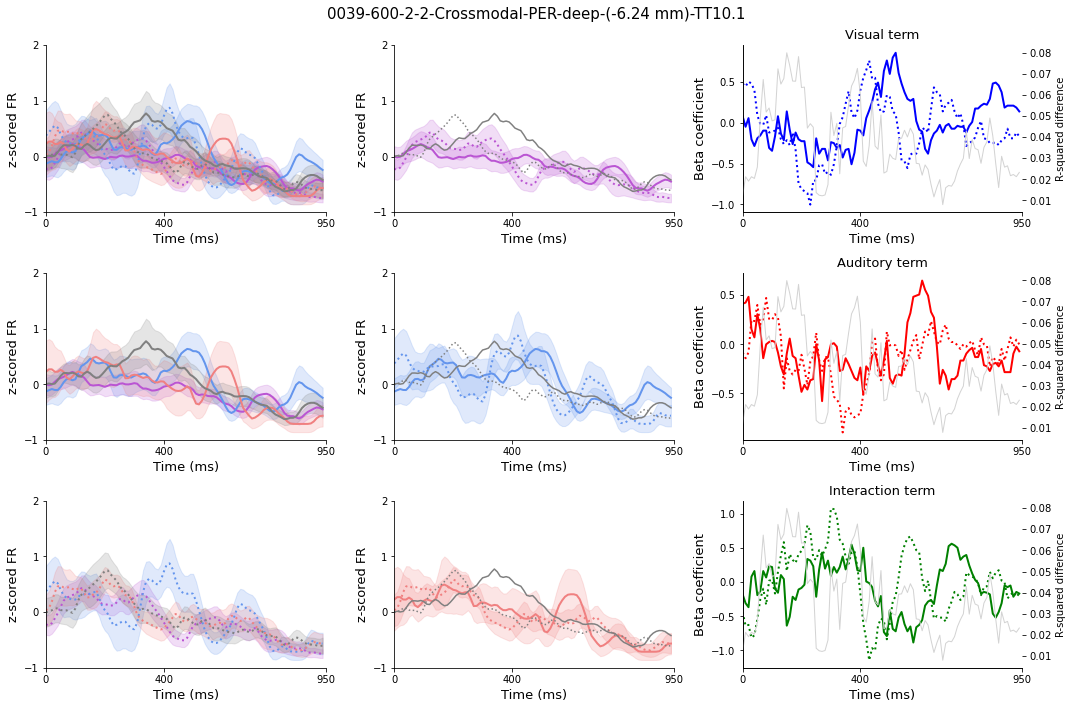

In [14]:
%%time
for cell_run,cell_name in enumerate(cell_list):
    loop_start = time.time()
    # get information about the cell
    cell_info = cell_name.split('-')
    cell_id = int(cell_info[0])
    rat_id = cell_info[1]
    session_id = cell_info[2]
    region = cell_info[5]    
    
    df = pd.read_csv(data_path+cell_name)
    df.drop(df[df.Correctness==0].index,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df[['Visual','Auditory']] = df[['Visual','Auditory']].fillna('no')
    
    boy_goal = df.loc[df['Visual']=='Boy','RWD_Loc'].values[0]
    boy_aud = df.loc[df['RWD_Loc']==boy_goal,'Auditory'].values[0]
    
    egg_goal = df.loc[df['Visual']=='Egg','RWD_Loc'].values[0]
    egg_aud = df.loc[df['RWD_Loc']==egg_goal,'Auditory'].values[0]  
    
    df['Boy-V'] = (df['Visual'] == 'Boy').astype(int)
    df['Boy-A'] = (df['Auditory'] == boy_aud).astype(int)
    df['Egg-V'] = (df['Visual'] == 'Egg').astype(int)
    df['Egg-A'] = (df['Auditory'] == egg_aud).astype(int)
    
    df['Boy-int'] = df['Boy-V']*df['Boy-A']
    df['Egg-int'] = df['Egg-V']*df['Egg-A']
    
    df['Choice'] = (df['RWD_Loc']==boy_goal).astype(int)   
    
    fr_id = df.columns.get_loc('Var10')  # get the index of the first firing rate column
    fr = df.iloc[:,fr_id:fr_id+95].to_numpy()
      
    cond_id = groupby_index(df)
    
    beta_coef = np.zeros((num_shuffle,95,6))
    beta_coef_choice = np.zeros((num_shuffle,95,7))
    beta_coef_shuffle = np.zeros((num_shuffle,95,6))
    beta_coef_choice_shuffle = np.zeros((num_shuffle,95,7))
    
    rsquare = np.zeros((num_shuffle,95))
    rsquare_choice = np.zeros((num_shuffle,95))
    rsquare_shuffle = np.zeros((num_shuffle,95))
    rsquare_choice_shuffle = np.zeros((num_shuffle,95))
        
    # subsampling   
    for i in range(num_shuffle):
        # subsample 5 trials from each stimulus condition
        subsample = np.array([])
        for c in cond_id:
            subsample = np.append(subsample,np.random.choice(c,5,replace=True))        
        subsample = np.asarray(subsample,dtype=int)
    
        # set regressors for the reduced and full model
        x1 = df.loc[subsample,['Boy-V','Boy-A','Boy-int','Egg-V','Egg-A','Egg-int']]
        x2 = df.loc[subsample,['Boy-V','Boy-A','Boy-int','Egg-V','Egg-A','Egg-int','Choice']]    
            
        # shuffle trial conditions to get null distribution
        state = np.random.get_state()
        x1_shuffle = np.random.permutation(x1)
        np.random.set_state(state)
        x2_shuffle = np.random.permutation(x2)
    
        # calculate beta coefficients and r-squared values using parallel computing
        results = Parallel(n_jobs=-1)(delayed(compute_regression)(t) for t in range(95))
        
        beta_coef[i,:,:] = np.array([result[0] for result in results])
        beta_coef_choice[i,:,:] = np.array([result[1] for result in results])
        beta_coef_shuffle[i,:,:] = np.array([result[2] for result in results])
        beta_coef_choice_shuffle[i,:,:] = np.array([result[3] for result in results])
        
        rsquare[i,:] = np.array([result[4] for result in results])
        rsquare_choice[i,:] = np.array([result[5] for result in results])   
        rsquare_shuffle[i,:] = np.array([result[6] for result in results])
        rsquare_choice_shuffle[i,:] = np.array([result[7] for result in results])          

    beta_mean = np.mean(beta_coef,axis=0)
    beta_std = np.std(beta_coef,axis=0)    
    
    r_diff = np.mean(rsquare_choice,axis=0)-np.mean(rsquare,axis=0)
    
    # find bins with significant differences in beta coefficients between two objects
    vis_diff = beta_coef_shuffle[:,:,0] - beta_coef_shuffle[:,:,3]
    aud_diff = beta_coef_shuffle[:,:,1] - beta_coef_shuffle[:,:,4]
    vis_crit = np.percentile(np.ravel(vis_diff), [2.5, 97.5])
    aud_crit = np.percentile(aud_diff, [2.5, 97.5])        
    vis_sig_bin = np.where(((beta_mean[:,0]-beta_mean[:,3])>vis_crit[1])|((beta_mean[:,0]-beta_mean[:,3])<vis_crit[0]))
    aud_sig_bin = np.where(((beta_mean[:,1]-beta_mean[:,4])>aud_crit[1])|((beta_mean[:,1]-beta_mean[:,4])<aud_crit[0]))        
    plot_SDF_beta(df,2,1,1,'png')
    
    save_result(f)
            
    loop_end = time.time()
    loop_time = divmod(loop_end-loop_start,60)
    print(cell_name.strip('.csv'), f'////// {cell_run+1}/{len(cell_list)} completed  //////  {int(loop_time[0])} min {loop_time[1]:.2f} sec')

In [15]:
f.close()
print('END')

END
